In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

train_PATH = '/content/drive/MyDrive/CV_Project3_Dataset/Dataset/Dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train'
files = os.listdir(train_PATH)

annotation_PATH = '/content/drive/MyDrive/CV_Project3_Dataset/Dataset/Dataset/annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train'
annotations = os.listdir(annotation_PATH)

print('n files: ', len(files))
print('n annotations: ', len(annotations))

n files:  367
n annotations:  367


In [ ]:
import matplotlib.pyplot as plt

def imshow(image):
  plt.imshow(image)
  plt.show()

0006R0_f01920.png
image


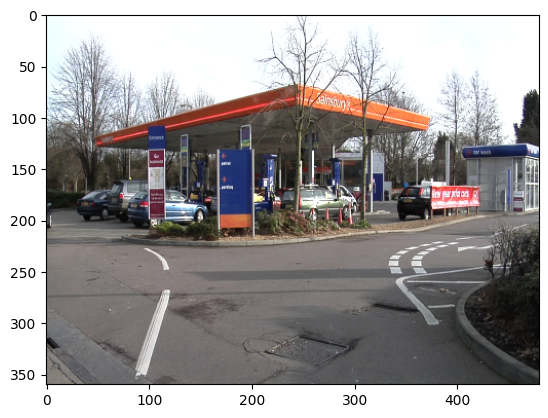

mask


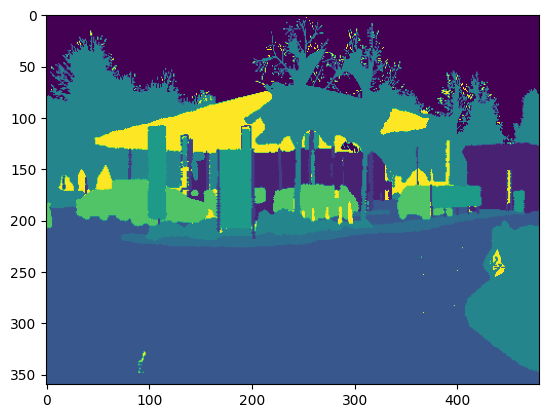

annotation


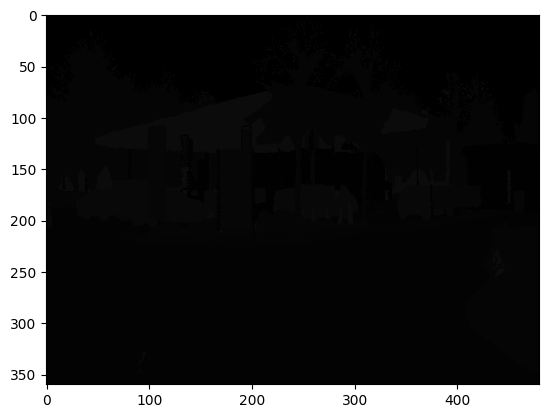

In [ ]:
import numpy as np

from PIL import Image

img_array = []
mask_array = []

print(files[0])

'''
for idx in range(len(files)):
  file_img = os.path.join(train_PATH, files[idx])
  img_array.append(file_img)

for i in range(len(annotations)):
  file_annotation = os.path.join(annotation_PATH, annotations[i])
  mask_array.append(file_annotation)
'''

file_img = os.path.join(train_PATH, files[0])

file_masks = os.path.join(annotation_PATH, f'{files[0]}')

# display an image
image = Image.open(file_img).convert('RGB')
print('image')
image = np.array(image)
imshow(image)

# display a mask
print('mask')
mask = Image.open(file_masks)
mask = np.asarray(mask)
imshow(mask)

# display an annotation
annotation = Image.open(file_masks).convert('RGB')
print('annotation')
annotation = np.array(annotation)
imshow(annotation)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

data_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
class InputData(Dataset):
  def __init__(self, files_list):
    super().__init__()
    self.files_list = files_list

  def __len__(self):
    return len(self.files_list)

  def __getitem__(self, idx):
    file_img = os.path.join(train_PATH, files[idx])

    file_masks = os.path.join(annotation_PATH, f'{files[idx]}')

    image = Image.open(file_img).convert('RGB')
    image = np.array(image)

    mask = Image.open(file_masks)
    mask = np.asarray(mask)

    output = data_transforms(image=image, mask=mask)
    image = output['image']
    masks = output['mask']

    return image, masks.unsqueeze(0)/255

In [ ]:
split = 0.8

for i in range(10):
  np.random.shuffle(files)

train_files = files[:int(len(files)*split)]
val_files = files[int(len(files)*split):]

In [ ]:
train_datasets = InputData(train_files)
val_datasets = InputData(val_files)

In [ ]:
train_datasets[1]

(tensor([[[ 2.2489,  2.2489,  2.2489,  ..., -1.3473, -1.3987, -1.3815],
          [ 2.2489,  2.2489,  2.2489,  ..., -1.3473, -1.3644, -1.3987],
          [ 2.2489,  2.2489,  2.2489,  ..., -1.3644, -1.3644, -1.3644],
          ...,
          [-0.7993, -0.8507, -0.7650,  ..., -1.0904, -1.0904, -1.0390],
          [-0.7822, -0.7650, -0.7479,  ..., -1.0733, -1.0390, -1.0733],
          [-0.7479, -0.7137, -0.8164,  ..., -1.0048, -0.9877, -1.0390]],
 
         [[ 2.4286,  2.4286,  2.4286,  ..., -1.2479, -1.3004, -1.2829],
          [ 2.4286,  2.4286,  2.4286,  ..., -1.2479, -1.2654, -1.3004],
          [ 2.4286,  2.4286,  2.4286,  ..., -1.2654, -1.2654, -1.2654],
          ...,
          [-0.6877, -0.7402, -0.6527,  ..., -0.9678, -0.9678, -0.9153],
          [-0.6527, -0.6352, -0.6176,  ..., -0.9503, -0.9328, -0.9503],
          [-0.6176, -0.5826, -0.6877,  ..., -0.8803, -0.8627, -0.9153]],
 
         [[ 2.6400,  2.6400,  2.6400,  ..., -1.0201, -1.0724, -1.0550],
          [ 2.6400,  2.6400,

In [ ]:
train_dataloader = DataLoader(train_datasets, batch_size=8, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_datasets, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

    def test():
      x = torch.randn((3, 1, 160, 160))
      model = UNET(in_channels=1, out_channels=1)
      preds = model(x)
      assert preds.shape == x.shape

In [ ]:
model = UNET(in_channels=3, out_channels=1)
model.cuda()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.0003)

In [ ]:
from tqdm import tqdm
scaler = torch.amp.GradScaler('cuda')

def train_engine(dataloader, model, loss_fn, optim, scaler=scaler):
    model.train()
    loss_one_step = 0
    loop = tqdm(dataloader)
    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.float().to(device="cuda")
        # forward
        with torch.amp.autocast('cuda'):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        loss_one_step += loss.item()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    return loss_one_step / len(dataloader)

def val_engine(dataloader, model, loss_fn):
    model.eval()
    loss_one_step = 0
    loop = tqdm(dataloader)

    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.float().to(device="cuda")
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                predictions = model(data)
                loss = loss_fn(predictions, targets)
        loss_one_step += loss.item()

        loop.set_postfix(loss=loss.item())

    return loss_one_step / len(dataloader)

In [ ]:
def train(train_dataloaders, val_dataloaders, model, loss_fn, optim, num_epochs, log_freq=10, save_best_model=False, best_model_name='best_model.pth', last_model_name='last_model.pth'):
    """
    Train the model for a given number of epochs.
    :param train_dataloaders: A dictionary of dataloaders for training and validation.
    :param val_dataloaders: A dictionary of dataloaders for validation.
    :param model: The model to train.
    :param loss_fn: The loss function to use.
    :param optim: The optimizer to use.
    :param num_epochs: The number of epochs to train for.
    :param log_freq: The frequency with which to log training metrics.
    :return: The trained model.
    """
    best_model = None
    best_val_loss = float('inf')

    best_model_name = os.path.join('/content/drive/MyDrive/CV_Project3_Dataset/model_save', best_model_name)
    last_model_name = os.path.join('/content/drive/MyDrive/CV_Project3_Dataset/model_save', last_model_name)

    for epoch in range(num_epochs):
        train_loss = train_engine(train_dataloaders, model, loss_fn, optim)
        val_loss = val_engine(val_dataloaders, model, loss_fn)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if save_best_model:
                best_model = model
                torch.save(best_model.state_dict(), best_model_name)
                torch.save(model.state_dict(), last_model_name)

        if epoch % log_freq == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            print('Train Loss: {:.4f}'.format(train_loss))
            print('Val Loss: {:.4f}'.format(val_loss))
            print()

    return model

In [ ]:
model = train(train_dataloader, val_dataloader, model, loss_fn, optim, 100, log_freq=1)

100%|██████████| 10/10 [00:01<00:00,  6.77it/s, loss=0.376]


Epoch 0/99
----------
Train Loss: 0.4395
Val Loss: 0.3859



100%|██████████| 10/10 [00:01<00:00,  5.48it/s, loss=0.282]


Epoch 1/99
----------
Train Loss: 0.2855
Val Loss: 0.2854



100%|██████████| 10/10 [00:01<00:00,  7.55it/s, loss=0.224]


Epoch 2/99
----------
Train Loss: 0.2324
Val Loss: 0.2219



100%|██████████| 10/10 [00:01<00:00,  6.94it/s, loss=0.177]


Epoch 3/99
----------
Train Loss: 0.1933
Val Loss: 0.1784



100%|██████████| 10/10 [00:01<00:00,  5.90it/s, loss=0.152]


Epoch 4/99
----------
Train Loss: 0.1648
Val Loss: 0.1526



100%|██████████| 10/10 [00:01<00:00,  7.43it/s, loss=0.132]


Epoch 5/99
----------
Train Loss: 0.1440
Val Loss: 0.1338



100%|██████████| 10/10 [00:01<00:00,  6.49it/s, loss=0.113]


Epoch 6/99
----------
Train Loss: 0.1275
Val Loss: 0.1182



100%|██████████| 10/10 [00:01<00:00,  6.75it/s, loss=0.109]


Epoch 7/99
----------
Train Loss: 0.1148
Val Loss: 0.1084



100%|██████████| 10/10 [00:01<00:00,  7.65it/s, loss=0.103]


Epoch 8/99
----------
Train Loss: 0.1049
Val Loss: 0.0993



100%|██████████| 10/10 [00:01<00:00,  6.70it/s, loss=0.0913]


Epoch 9/99
----------
Train Loss: 0.0969
Val Loss: 0.0906



100%|██████████| 10/10 [00:01<00:00,  6.70it/s, loss=0.0833]


Epoch 10/99
----------
Train Loss: 0.0904
Val Loss: 0.0860



100%|██████████| 10/10 [00:01<00:00,  7.52it/s, loss=0.0844]


Epoch 11/99
----------
Train Loss: 0.0853
Val Loss: 0.0812



100%|██████████| 10/10 [00:01<00:00,  6.80it/s, loss=0.0695]


Epoch 12/99
----------
Train Loss: 0.0812
Val Loss: 0.0769



100%|██████████| 10/10 [00:01<00:00,  6.86it/s, loss=0.0709]


Epoch 13/99
----------
Train Loss: 0.0779
Val Loss: 0.0749



100%|██████████| 10/10 [00:01<00:00,  7.54it/s, loss=0.0765]


Epoch 14/99
----------
Train Loss: 0.0751
Val Loss: 0.0725



100%|██████████| 10/10 [00:01<00:00,  6.46it/s, loss=0.0589]


Epoch 15/99
----------
Train Loss: 0.0730
Val Loss: 0.0695



100%|██████████| 10/10 [00:01<00:00,  6.75it/s, loss=0.0749]


Epoch 16/99
----------
Train Loss: 0.0711
Val Loss: 0.0690



100%|██████████| 10/10 [00:01<00:00,  7.80it/s, loss=0.0722]


Epoch 17/99
----------
Train Loss: 0.0696
Val Loss: 0.0679



100%|██████████| 10/10 [00:01<00:00,  6.83it/s, loss=0.0563]


Epoch 18/99
----------
Train Loss: 0.0683
Val Loss: 0.0656



100%|██████████| 10/10 [00:01<00:00,  6.71it/s, loss=0.0582]


Epoch 19/99
----------
Train Loss: 0.0673
Val Loss: 0.0646



100%|██████████| 10/10 [00:01<00:00,  7.50it/s, loss=0.0674]


Epoch 20/99
----------
Train Loss: 0.0664
Val Loss: 0.0646



100%|██████████| 10/10 [00:01<00:00,  6.59it/s, loss=0.061]


Epoch 21/99
----------
Train Loss: 0.0657
Val Loss: 0.0628



100%|██████████| 10/10 [00:01<00:00,  6.64it/s, loss=0.0663]


Epoch 22/99
----------
Train Loss: 0.0651
Val Loss: 0.0633



100%|██████████| 10/10 [00:01<00:00,  7.69it/s, loss=0.0699]


Epoch 23/99
----------
Train Loss: 0.0645
Val Loss: 0.0629



100%|██████████| 10/10 [00:01<00:00,  6.57it/s, loss=0.0637]


Epoch 24/99
----------
Train Loss: 0.0640
Val Loss: 0.0630



100%|██████████| 10/10 [00:01<00:00,  6.68it/s, loss=0.0645]


Epoch 25/99
----------
Train Loss: 0.0637
Val Loss: 0.0617



100%|██████████| 10/10 [00:01<00:00,  7.84it/s, loss=0.0623]


Epoch 26/99
----------
Train Loss: 0.0633
Val Loss: 0.0616



100%|██████████| 10/10 [00:01<00:00,  6.19it/s, loss=0.0558]


Epoch 27/99
----------
Train Loss: 0.0630
Val Loss: 0.0606



100%|██████████| 10/10 [00:01<00:00,  7.40it/s, loss=0.0685]


Epoch 28/99
----------
Train Loss: 0.0627
Val Loss: 0.0614



100%|██████████| 10/10 [00:01<00:00,  7.34it/s, loss=0.0678]


Epoch 29/99
----------
Train Loss: 0.0625
Val Loss: 0.0621



100%|██████████| 10/10 [00:01<00:00,  6.37it/s, loss=0.066]


Epoch 30/99
----------
Train Loss: 0.0623
Val Loss: 0.0609



100%|██████████| 10/10 [00:01<00:00,  6.63it/s, loss=0.0618]


Epoch 31/99
----------
Train Loss: 0.0620
Val Loss: 0.0607



100%|██████████| 10/10 [00:01<00:00,  7.58it/s, loss=0.0672]


Epoch 32/99
----------
Train Loss: 0.0618
Val Loss: 0.0607



100%|██████████| 10/10 [00:01<00:00,  6.41it/s, loss=0.0518]


Epoch 33/99
----------
Train Loss: 0.0617
Val Loss: 0.0594



100%|██████████| 10/10 [00:01<00:00,  6.59it/s, loss=0.0585]


Epoch 34/99
----------
Train Loss: 0.0616
Val Loss: 0.0601



100%|██████████| 10/10 [00:01<00:00,  7.75it/s, loss=0.0531]


Epoch 35/99
----------
Train Loss: 0.0615
Val Loss: 0.0594



100%|██████████| 10/10 [00:01<00:00,  6.77it/s, loss=0.0655]


Epoch 36/99
----------
Train Loss: 0.0615
Val Loss: 0.0599



100%|██████████| 10/10 [00:01<00:00,  6.42it/s, loss=0.046]


Epoch 37/99
----------
Train Loss: 0.0613
Val Loss: 0.0583



100%|██████████| 10/10 [00:01<00:00,  7.98it/s, loss=0.057]


Epoch 38/99
----------
Train Loss: 0.0612
Val Loss: 0.0594



100%|██████████| 10/10 [00:01<00:00,  6.86it/s, loss=0.0599]


Epoch 39/99
----------
Train Loss: 0.0611
Val Loss: 0.0595



100%|██████████| 10/10 [00:01<00:00,  6.83it/s, loss=0.0508]


Epoch 40/99
----------
Train Loss: 0.0609
Val Loss: 0.0585



100%|██████████| 10/10 [00:01<00:00,  7.72it/s, loss=0.0679]


Epoch 41/99
----------
Train Loss: 0.0610
Val Loss: 0.0603



100%|██████████| 10/10 [00:01<00:00,  6.40it/s, loss=0.062]


Epoch 42/99
----------
Train Loss: 0.0610
Val Loss: 0.0601



100%|██████████| 10/10 [00:01<00:00,  6.62it/s, loss=0.0539]


Epoch 43/99
----------
Train Loss: 0.0609
Val Loss: 0.0586



100%|██████████| 10/10 [00:01<00:00,  7.76it/s, loss=0.056]


Epoch 44/99
----------
Train Loss: 0.0609
Val Loss: 0.0588



100%|██████████| 10/10 [00:01<00:00,  6.78it/s, loss=0.0562]


Epoch 45/99
----------
Train Loss: 0.0609
Val Loss: 0.0588



100%|██████████| 10/10 [00:01<00:00,  6.69it/s, loss=0.0602]


Epoch 46/99
----------
Train Loss: 0.0607
Val Loss: 0.0592



100%|██████████| 10/10 [00:01<00:00,  7.82it/s, loss=0.0695]


Epoch 47/99
----------
Train Loss: 0.0608
Val Loss: 0.0597



100%|██████████| 10/10 [00:01<00:00,  6.88it/s, loss=0.0577]


Epoch 48/99
----------
Train Loss: 0.0607
Val Loss: 0.0589



100%|██████████| 10/10 [00:01<00:00,  6.43it/s, loss=0.0669]


Epoch 49/99
----------
Train Loss: 0.0607
Val Loss: 0.0597



100%|██████████| 10/10 [00:01<00:00,  7.57it/s, loss=0.048]


Epoch 50/99
----------
Train Loss: 0.0606
Val Loss: 0.0579



100%|██████████| 10/10 [00:01<00:00,  6.53it/s, loss=0.0543]


Epoch 51/99
----------
Train Loss: 0.0606
Val Loss: 0.0587



100%|██████████| 10/10 [00:01<00:00,  5.90it/s, loss=0.0492]


Epoch 52/99
----------
Train Loss: 0.0605
Val Loss: 0.0589



100%|██████████| 10/10 [00:01<00:00,  7.49it/s, loss=0.0563]


Epoch 53/99
----------
Train Loss: 0.0606
Val Loss: 0.0584



100%|██████████| 10/10 [00:01<00:00,  6.90it/s, loss=0.053]


Epoch 54/99
----------
Train Loss: 0.0605
Val Loss: 0.0587



100%|██████████| 10/10 [00:01<00:00,  6.46it/s, loss=0.064]


Epoch 55/99
----------
Train Loss: 0.0605
Val Loss: 0.0593



100%|██████████| 10/10 [00:01<00:00,  7.52it/s, loss=0.0655]


Epoch 56/99
----------
Train Loss: 0.0604
Val Loss: 0.0592



100%|██████████| 10/10 [00:01<00:00,  6.86it/s, loss=0.0533]


Epoch 57/99
----------
Train Loss: 0.0605
Val Loss: 0.0585



100%|██████████| 10/10 [00:01<00:00,  6.63it/s, loss=0.0612]


Epoch 58/99
----------
Train Loss: 0.0604
Val Loss: 0.0588



100%|██████████| 10/10 [00:01<00:00,  7.50it/s, loss=0.0641]


Epoch 59/99
----------
Train Loss: 0.0604
Val Loss: 0.0594



100%|██████████| 10/10 [00:01<00:00,  6.67it/s, loss=0.0574]


Epoch 60/99
----------
Train Loss: 0.0604
Val Loss: 0.0594



100%|██████████| 10/10 [00:01<00:00,  6.35it/s, loss=0.0496]


Epoch 61/99
----------
Train Loss: 0.0604
Val Loss: 0.0578



100%|██████████| 10/10 [00:01<00:00,  7.42it/s, loss=0.0677]


Epoch 62/99
----------
Train Loss: 0.0603
Val Loss: 0.0599



100%|██████████| 10/10 [00:01<00:00,  6.72it/s, loss=0.0579]


Epoch 63/99
----------
Train Loss: 0.0603
Val Loss: 0.0584



100%|██████████| 10/10 [00:01<00:00,  6.55it/s, loss=0.0448]


Epoch 64/99
----------
Train Loss: 0.0604
Val Loss: 0.0574



100%|██████████| 10/10 [00:01<00:00,  7.46it/s, loss=0.0531]


Epoch 65/99
----------
Train Loss: 0.0603
Val Loss: 0.0581



100%|██████████| 10/10 [00:01<00:00,  6.72it/s, loss=0.0561]


Epoch 66/99
----------
Train Loss: 0.0604
Val Loss: 0.0585



100%|██████████| 10/10 [00:01<00:00,  6.61it/s, loss=0.0649]


Epoch 67/99
----------
Train Loss: 0.0603
Val Loss: 0.0589



100%|██████████| 10/10 [00:01<00:00,  7.64it/s, loss=0.0681]


Epoch 68/99
----------
Train Loss: 0.0603
Val Loss: 0.0592



100%|██████████| 10/10 [00:01<00:00,  6.70it/s, loss=0.0535]


Epoch 69/99
----------
Train Loss: 0.0602
Val Loss: 0.0584



100%|██████████| 10/10 [00:01<00:00,  6.52it/s, loss=0.051]


Epoch 70/99
----------
Train Loss: 0.0602
Val Loss: 0.0579



100%|██████████| 10/10 [00:01<00:00,  7.52it/s, loss=0.0563]


Epoch 71/99
----------
Train Loss: 0.0601
Val Loss: 0.0582



100%|██████████| 10/10 [00:01<00:00,  7.84it/s, loss=0.0557]


Epoch 72/99
----------
Train Loss: 0.0601
Val Loss: 0.0582



100%|██████████| 10/10 [00:01<00:00,  6.02it/s, loss=0.0471]


Epoch 73/99
----------
Train Loss: 0.0601
Val Loss: 0.0575



100%|██████████| 10/10 [00:01<00:00,  7.47it/s, loss=0.0495]


Epoch 74/99
----------
Train Loss: 0.0601
Val Loss: 0.0576



100%|██████████| 10/10 [00:01<00:00,  7.33it/s, loss=0.0475]


Epoch 75/99
----------
Train Loss: 0.0600
Val Loss: 0.0576



100%|██████████| 10/10 [00:01<00:00,  6.37it/s, loss=0.0524]


Epoch 76/99
----------
Train Loss: 0.0600
Val Loss: 0.0578



100%|██████████| 10/10 [00:01<00:00,  7.50it/s, loss=0.0754]


Epoch 77/99
----------
Train Loss: 0.0601
Val Loss: 0.0597



100%|██████████| 10/10 [00:01<00:00,  6.82it/s, loss=0.0614]


Epoch 78/99
----------
Train Loss: 0.0601
Val Loss: 0.0585



100%|██████████| 10/10 [00:01<00:00,  6.54it/s, loss=0.0472]


Epoch 79/99
----------
Train Loss: 0.0601
Val Loss: 0.0575



100%|██████████| 10/10 [00:01<00:00,  7.83it/s, loss=0.059]


Epoch 80/99
----------
Train Loss: 0.0601
Val Loss: 0.0583



100%|██████████| 10/10 [00:01<00:00,  6.95it/s, loss=0.0642]


Epoch 81/99
----------
Train Loss: 0.0600
Val Loss: 0.0587



100%|██████████| 10/10 [00:01<00:00,  6.09it/s, loss=0.0513]


Epoch 82/99
----------
Train Loss: 0.0600
Val Loss: 0.0576



100%|██████████| 10/10 [00:01<00:00,  7.74it/s, loss=0.0682]


Epoch 83/99
----------
Train Loss: 0.0600
Val Loss: 0.0589



100%|██████████| 10/10 [00:01<00:00,  7.14it/s, loss=0.0531]


Epoch 84/99
----------
Train Loss: 0.0599
Val Loss: 0.0577



100%|██████████| 10/10 [00:01<00:00,  6.40it/s, loss=0.0576]


Epoch 85/99
----------
Train Loss: 0.0599
Val Loss: 0.0582



100%|██████████| 10/10 [00:01<00:00,  7.61it/s, loss=0.0574]


Epoch 86/99
----------
Train Loss: 0.0600
Val Loss: 0.0582



100%|██████████| 10/10 [00:01<00:00,  7.22it/s, loss=0.0662]


Epoch 87/99
----------
Train Loss: 0.0600
Val Loss: 0.0588



100%|██████████| 10/10 [00:01<00:00,  5.58it/s, loss=0.0648]


Epoch 88/99
----------
Train Loss: 0.0600
Val Loss: 0.0587



100%|██████████| 10/10 [00:01<00:00,  7.71it/s, loss=0.0523]


Epoch 89/99
----------
Train Loss: 0.0600
Val Loss: 0.0578



100%|██████████| 10/10 [00:01<00:00,  7.56it/s, loss=0.0608]


Epoch 90/99
----------
Train Loss: 0.0599
Val Loss: 0.0588



100%|██████████| 10/10 [00:01<00:00,  5.46it/s, loss=0.063]


Epoch 91/99
----------
Train Loss: 0.0599
Val Loss: 0.0584



100%|██████████| 10/10 [00:01<00:00,  7.54it/s, loss=0.0575]


Epoch 92/99
----------
Train Loss: 0.0598
Val Loss: 0.0581



100%|██████████| 10/10 [00:01<00:00,  7.65it/s, loss=0.0584]


Epoch 93/99
----------
Train Loss: 0.0598
Val Loss: 0.0582



100%|██████████| 10/10 [00:01<00:00,  5.14it/s, loss=0.0638]


Epoch 94/99
----------
Train Loss: 0.0599
Val Loss: 0.0585



100%|██████████| 10/10 [00:01<00:00,  7.52it/s, loss=0.0606]


Epoch 95/99
----------
Train Loss: 0.0599
Val Loss: 0.0583



100%|██████████| 10/10 [00:01<00:00,  7.63it/s, loss=0.0568]


Epoch 96/99
----------
Train Loss: 0.0599
Val Loss: 0.0580



100%|██████████| 10/10 [00:01<00:00,  5.17it/s, loss=0.0737]


Epoch 97/99
----------
Train Loss: 0.0598
Val Loss: 0.0597



100%|██████████| 10/10 [00:01<00:00,  7.52it/s, loss=0.0661]


Epoch 98/99
----------
Train Loss: 0.0599
Val Loss: 0.0586



100%|██████████| 10/10 [00:01<00:00,  7.65it/s, loss=0.0545]

Epoch 99/99
----------
Train Loss: 0.0597
Val Loss: 0.0577



In [ ]:
class InputDataTest(Dataset):
  def __init__(self, files_list):
    super().__init__()
    self.files_list = files_list
    self.train = train

  def __len__(self):
    return len(self.files_list)

  def __getitem__(self, idx):
    file_img = os.path.join(train_PATH, files[idx])

    image = Image.open(file_img).convert('RGB')
    image = np.array(image)
    image_ori = image.copy()

    output = data_transforms(image=image)
    image = output['image']

    return image, image_ori

In [ ]:
def inference(tensor):
  with torch.no_grad():
    tensor = torch.unsqueeze(tensor, dim=0).to('cuda')
    result = model(tensor)
    result = torch.sigmoid(result)

  return result

def imshow_from_tensor(tensor):
  tensor = torch.squeeze(tensor)
  tensor = tensor.cpu().detach().numpy()
  imshow(tensor)

Predict: 


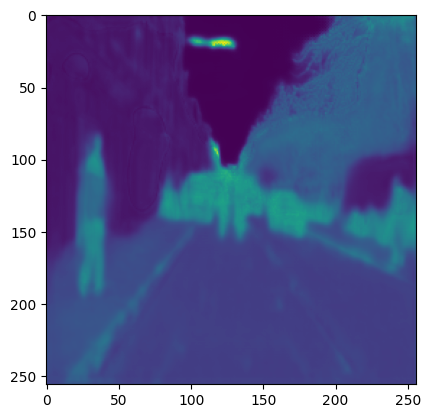

Groundtruth: 


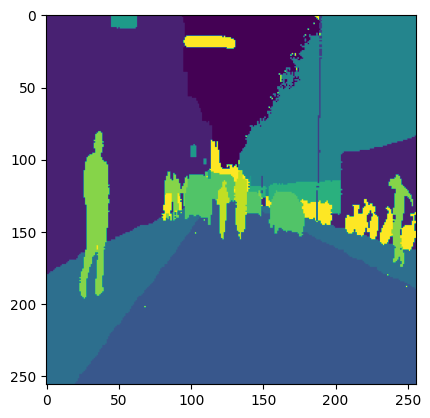

Predict: 


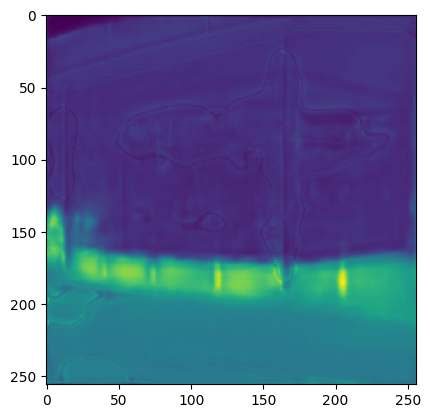

Groundtruth: 


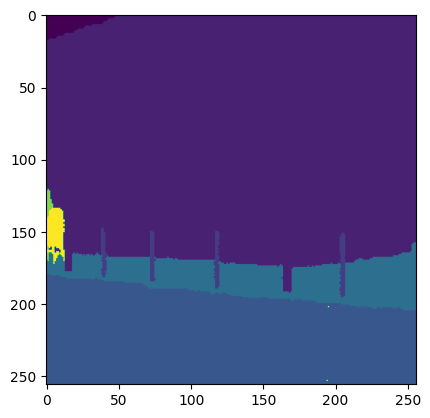

Predict: 


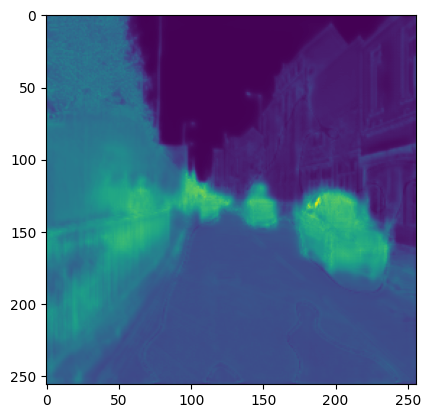

Groundtruth: 


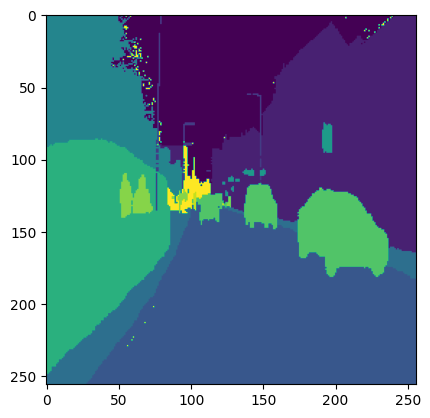

Predict: 


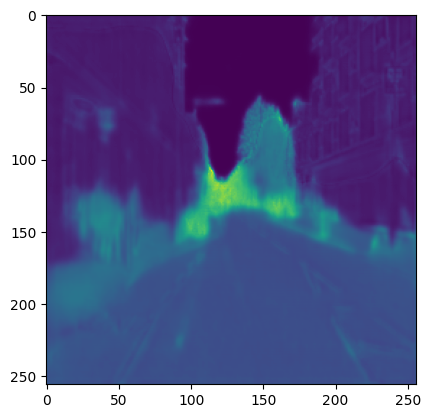

Groundtruth: 


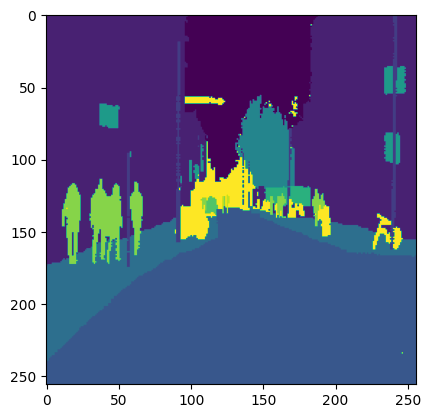

Predict: 


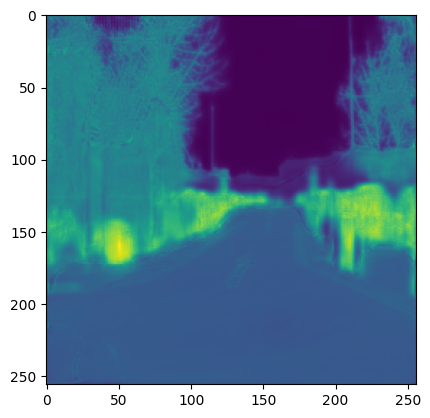

Groundtruth: 


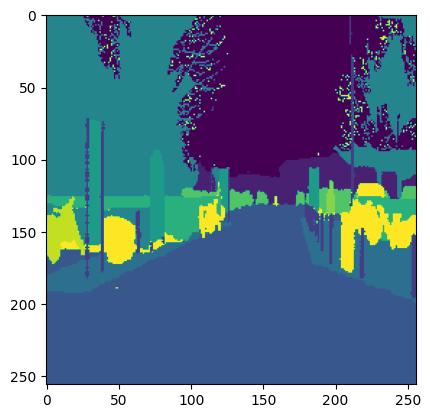

In [ ]:
get = 5

for i in range(get):
  data, targets = val_datasets[i]
  result = inference(data)
  print('Predict: ')
  imshow_from_tensor(result)
  print('Groundtruth: ')
  imshow_from_tensor(targets)

In [ ]:
PATH_TEST = '/content/drive/MyDrive/CV_Project3_Dataset/Dataset/Dataset/images_prepped_test-20230811T065241Z-001/images_prepped_test'
test_file_list = os.listdir(PATH_TEST)
print(test_file_list)

['0016E5_08159.png', '0016E5_08079.png', '0016E5_08011.png', '0016E5_08107.png', '0016E5_08137.png', '0016E5_08085.png', '0016E5_08025.png', '0016E5_08017.png', '0016E5_07987.png', '0016E5_07989.png', '0016E5_08131.png', '0016E5_08021.png', '0016E5_08089.png', '0016E5_08049.png', '0016E5_08141.png', '0016E5_07971.png', '0016E5_08071.png', '0016E5_08013.png', '0016E5_08065.png', '0016E5_08041.png', '0016E5_08055.png', '0016E5_08051.png', '0016E5_08069.png', '0016E5_08103.png', '0016E5_08139.png', '0016E5_08127.png', '0016E5_08039.png', '0016E5_08077.png', '0016E5_08083.png', '0016E5_08037.png', '0016E5_08035.png', '0016E5_08003.png', '0016E5_08075.png', '0016E5_08147.png', '0016E5_08097.png', '0016E5_08029.png', '0016E5_08105.png', '0016E5_08109.png', '0016E5_08043.png', '0016E5_07979.png', '0016E5_08095.png', '0016E5_08033.png', '0016E5_07993.png', '0016E5_07959.png', '0016E5_08153.png', '0016E5_07991.png', '0016E5_07981.png', '0016E5_08023.png', '0016E5_08073.png', '0016E5_07975.png',

In [ ]:
test_datasets = InputDataTest(test_file_list)

Prediction


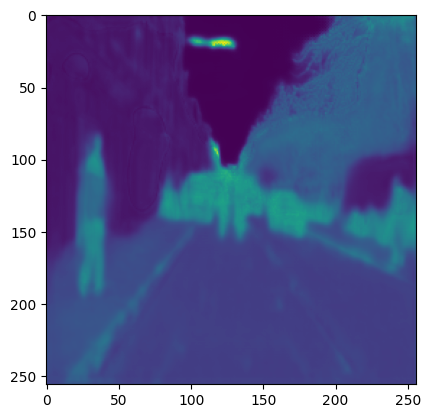

original_image


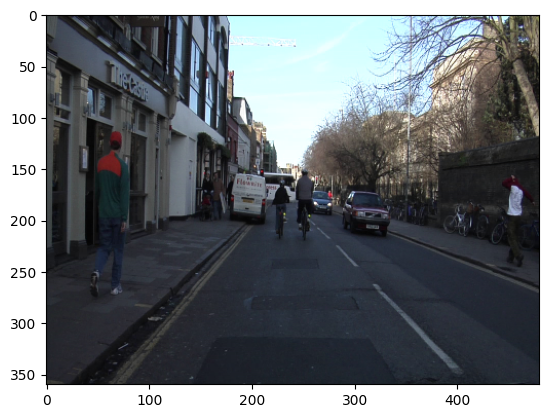

Prediction


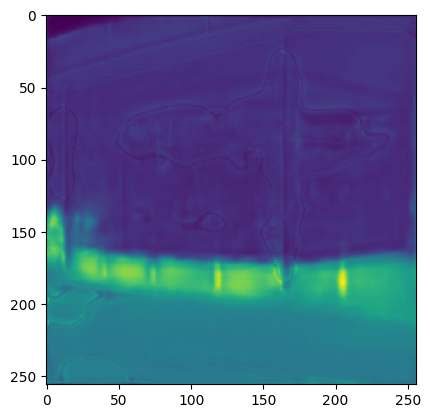

original_image


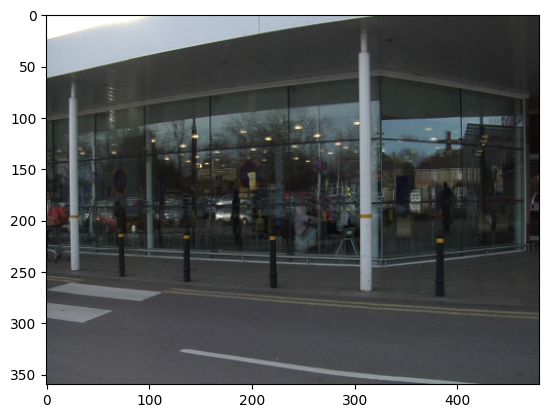

Prediction


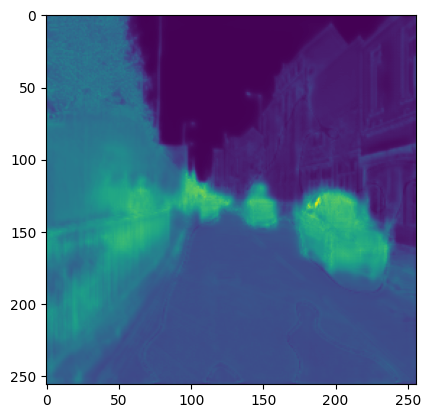

original_image


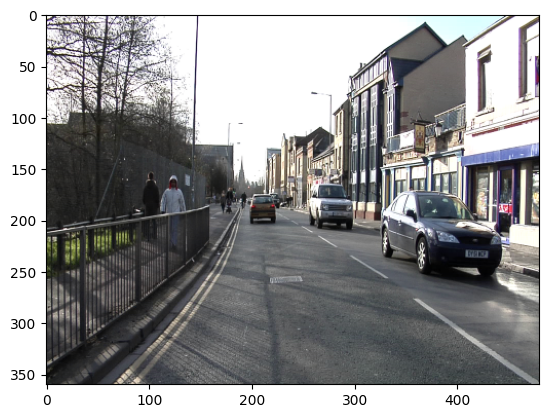

Prediction


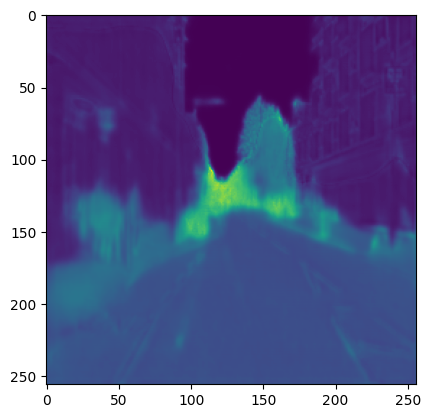

original_image


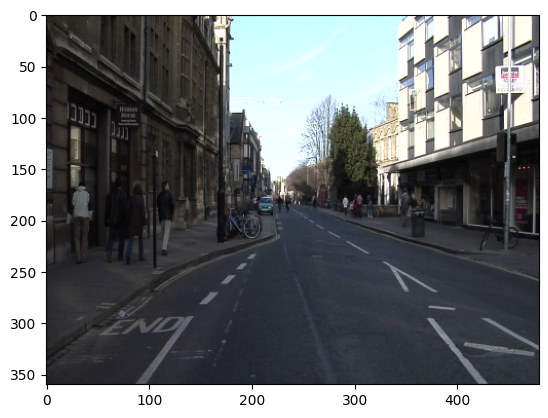

Prediction


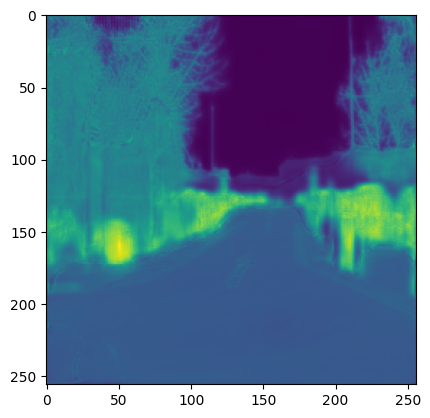

original_image


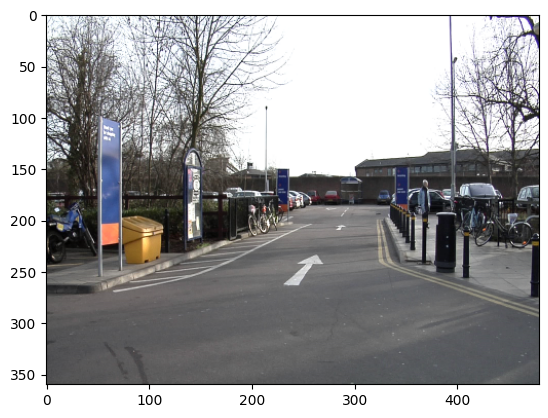

In [ ]:
get = 5

for i in range(get):
  data, image_ori = test_datasets[i]
  result = inference(data)
  print('Prediction')
  imshow_from_tensor(result)
  print('original_image')
  imshow(image_ori)